In [1]:
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt; import seaborn as sns

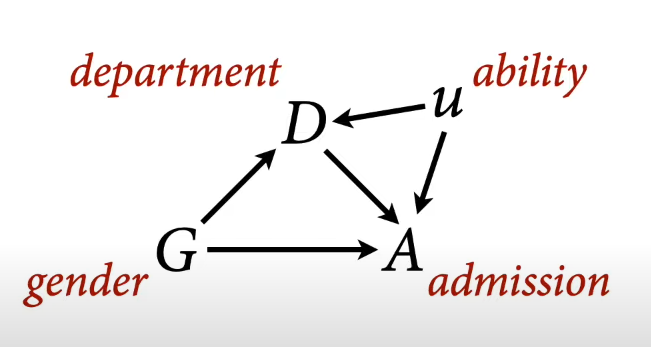

In [2]:
np.random.seed(1)

# Number of applicants
n_samples = 2000

# Gender equally likely
G = np.random.choice([0, 1], size=n_samples, replace=True)

# Unobserved Ability -- 10% have High, everyone else is Average
u = stats.bernoulli.rvs(p=0.1, size=n_samples)

# Choice of department
# G0 applies to D0 with 75% probability else D1 with 1% or 0% based on ability
D = stats.bernoulli.rvs(p=np.where(G==0, u * 1.0, 0.75))

# Ability-based acceptance rates (ability x dept x gender)
p_u0_dg = np.array([[0.1, 0.1], [0.1, 0.3]])
p_u1_dg = np.array([[0.3, 0.5], [0.3, 0.5]])
p_udg = np.array([p_u0_dg, p_u1_dg])
print("Acceptance Probabilities\n(ability x dept x gender):\n\n", p_udg)

# Simulate acceptance
p = p_udg[u, D, G]
A = stats.bernoulli.rvs(p=p)

Acceptance Probabilities
(ability x dept x gender):

 [[[0.1 0.1]
  [0.1 0.3]]

 [[0.3 0.5]
  [0.3 0.5]]]


In [3]:
A

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [4]:
D

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

### Total Effect Model

In [5]:
# Define coordinates
GENDER_ID, GENDER = pd.factorize(["G2" if g else "G1" for g in G], sort=True)
DEPTARTMENT_ID, DEPARTMENT = pd.factorize(["D2" if d else "D1" for d in D], sort=True)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_13988\983545468.py:2: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  GENDER_ID, GENDER = pd.factorize(["G2" if g else "G1" for g in G], sort=True)
C:\Users\Kuba\AppData\Local\Temp\ipykernel_13988\983545468.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  DEPTARTMENT_ID, DEPARTMENT = pd.factorize(["D2" if d else "D1" for d in D], sort=True)


In [6]:
# Define coordinates
GENDER_ID, GENDER = pd.factorize(["Female (G1)" if g==0 else "Male (G2)" for g in G], sort=True)
DEPTARTMENT_ID, DEPARTMENT = pd.factorize(["Medical Dept(D1)" if d==0 else "CompSci(D2)" for d in D], sort=True)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_13988\2664043693.py:2: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  GENDER_ID, GENDER = pd.factorize(["Female (G1)" if g==0 else "Male (G2)" for g in G], sort=True)
C:\Users\Kuba\AppData\Local\Temp\ipykernel_13988\2664043693.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  DEPTARTMENT_ID, DEPARTMENT = pd.factorize(["Medical Dept(D1)" if d==0 else "CompSci(D2)" for d in D], sort=True)


In [7]:
DEPARTMENT

array(['CompSci(D2)', 'Medical Dept(D1)'], dtype=object)

In [8]:
with pm.Model(coords={"gender": GENDER}) as total_effect_admissions_model:
    alpha = pm.Normal("alpha", 0, 1, dims='gender')
    
    # Likelihood
    p = pm.math.invlogit(alpha[GENDER_ID])
    pm.Bernoulli("admitted", p=p, observed=A)
    
    # Record the probability param for simpler reporting
    pm.Deterministic("p_admit", pm.math.invlogit(alpha), dims="gender")
    
    total_effect_admissions_inference = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


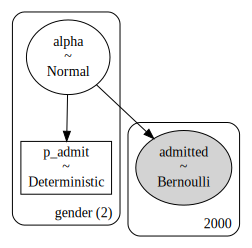

In [9]:
pm.model_to_graphviz(total_effect_admissions_model)

In [10]:
def summarize_posterior(inference, figsize=(5, 3)):
    """Helper function for displaying model fits"""
    _, axs = plt.subplots(2, 1, figsize=figsize)
    az.plot_forest(inference, var_names='alpha', combined=True, ax=axs[0])
    az.plot_forest(inference, var_names='p_admit', combined=True, ax=axs[1])
    plt.tight_layout()
    return az.summary(inference, var_names=["alpha", "p_admit"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Female (G1)],-1.999,0.094,-2.153,-1.805,0.002,0.001,2054.0,1595.0,1.0
alpha[Male (G2)],-1.096,0.074,-1.237,-0.964,0.002,0.001,2102.0,1676.0,1.0
p_admit[Female (G1)],0.120,0.010,0.101,0.138,0.000,0.000,2054.0,1595.0,1.0
p_admit[Male (G2)],0.251,0.014,0.225,0.276,0.000,0.000,2102.0,1676.0,1.0


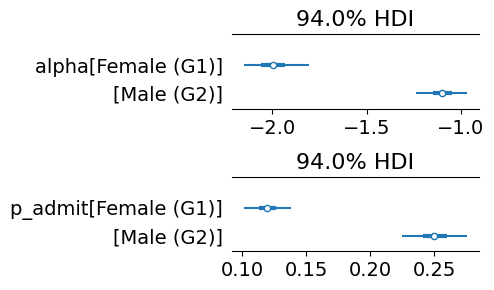

In [11]:
summarize_posterior(inference=total_effect_admissions_inference)

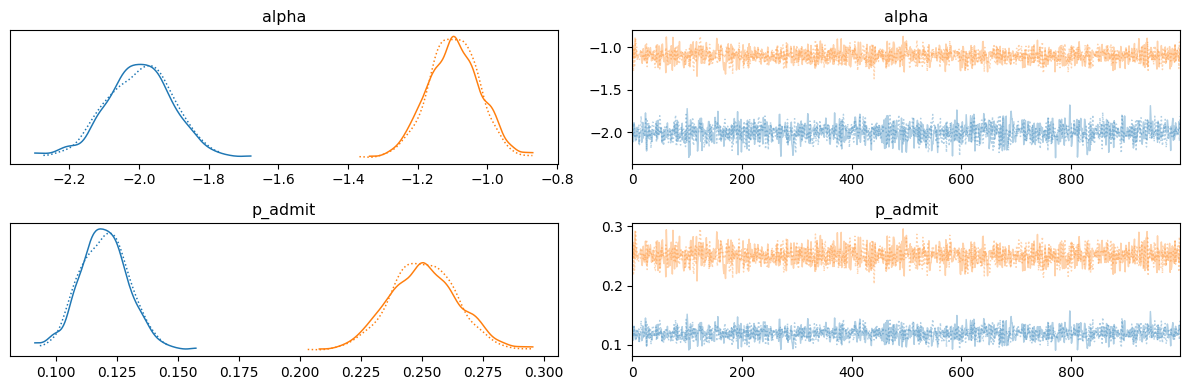

In [12]:
az.plot_trace(data=total_effect_admissions_inference); plt.tight_layout()

### Fit the confounded direct effect

In [13]:
DEPTARTMENT_ID

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [14]:
with pm.Model(coords={"gender": GENDER, "department": DEPARTMENT}) as direct_effect_addmissions_model_confounded:
    alpha = pm.Normal("alpha", 0, 1, dims=['gender', 'department'])
    
    # Likelihood
    p = pm.math.invlogit(alpha[GENDER_ID, DEPTARTMENT_ID])
    pm.Bernoulli("admitted", p=p, observed=A)
    
    # Record the probability param for simpler reporting
    pm.Deterministic("p_admit", pm.math.invlogit(alpha), dims=["gender", "department"])
    
    direct_effect_addmissions_confounded_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[Female (G1), CompSci(D2)]",-0.994,0.218,-1.371,-0.568,0.004,0.003,3524.0,1694.0,1.0
"alpha[Female (G1), Medical Dept(D1)]",-2.149,0.108,-2.354,-1.954,0.002,0.001,3183.0,1660.0,1.0
"alpha[Male (G2), CompSci(D2)]",-0.954,0.082,-1.112,-0.803,0.002,0.001,2912.0,1391.0,1.0
"alpha[Male (G2), Medical Dept(D1)]",-1.542,0.171,-1.850,-1.207,0.003,0.002,2877.0,1549.0,1.0
"p_admit[Female (G1), CompSci(D2)]",0.272,0.043,0.191,0.348,0.001,0.001,3524.0,1694.0,1.0
"p_admit[Female (G1), Medical Dept(D1)]",0.105,0.010,0.087,0.124,0.000,0.000,3183.0,1660.0,1.0
"p_admit[Male (G2), CompSci(D2)]",0.278,0.016,0.247,0.309,0.000,0.000,2912.0,1391.0,1.0
"p_admit[Male (G2), Medical Dept(D1)]",0.178,0.025,0.132,0.225,0.000,0.000,2877.0,1549.0,1.0


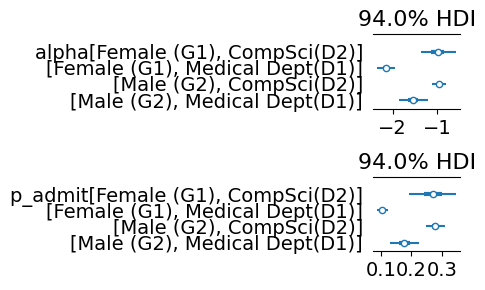

In [15]:
summarize_posterior(inference=direct_effect_addmissions_confounded_inference)

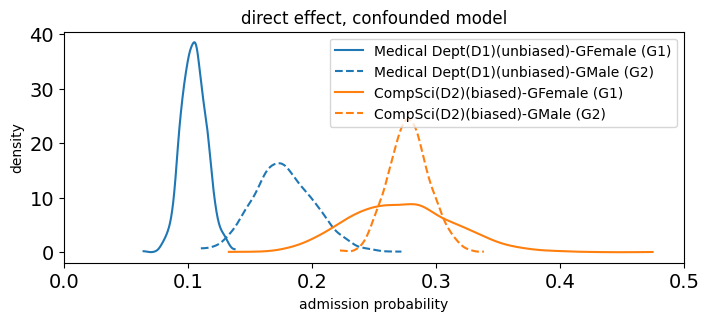

In [16]:
def plot_department_gender_admissions(inference, title):
    plt.subplots(figsize=(8, 3))
    for ii, dept in enumerate(["Medical Dept(D1)", "CompSci(D2)"]):
        for jj, gend in enumerate(["Female (G1)", "Male (G2)"]):
            # note inverse link function applied
            post = inference.posterior
            post_p_accept = post.sel(department=dept, gender=gend)['p_admit']
            label=f'{dept}({"biased" if ii else "unbiased"})-G{gend}'
            color=f'C{np.abs(ii)}'  # flip colorscale to match lecture
            linestyle= '--' if jj else "-"
            az.plot_dist(
                post_p_accept,
                color=color,
                label=label,
                plot_kwargs=dict(linestyle=linestyle),
            )
    plt.xlim([0, .5])
    plt.xlabel("admission probability")
    plt.ylabel("density")
    plt.title(title);
    
plot_department_gender_admissions(direct_effect_addmissions_confounded_inference, 'direct effect, confounded model')

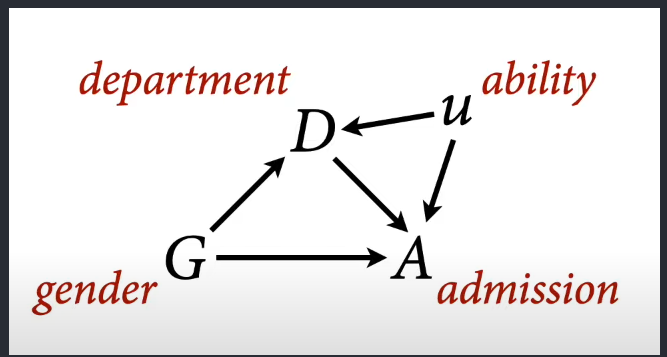

Collider Bias

#### Interpreting the Confounded Direct Effect Model
- In D1, G1 appears to be disatvantaged, with a lower admission rate. However, we know this isn't true. What's happening is that all the higher-ability G1 applicants are being sent to D2, thus artificially lowering the G1 acceptance rate in D1
- We know that there is bias in D2, however, we see little evidence for discrimination. This is due to higher-ability G1 applicatins ofsetting this bias by having higher-than-average acceptance
- We can see that G1 estimates for D2 have higher variance; this is due to there being only 10% of applicants having high ability, thus fewer G1 applicants overall apply to D2.


- Estimating Direct effect includes Department in the adjustment set
- However, stratifying by Department (collider)  opens a confounder backdoor path through unobserved ability, u

$$
\begin{align*}
A_i &\sim \text{Bernoulli}(p=p_i) \\
\text{logit}(p_i) &= \alpha_{[D_i, G_i]} \\
\alpha &= \begin{bmatrix} \alpha_{0,0}, \alpha_{0,1} \\  \alpha_{1,0}, \alpha_{1,1} \end{bmatrix} \\
\alpha_{j,k} &\sim \text{Normal}(0, 1)
\end{align*}
$$

#### Example featuring 2 papers examinining the same population and reaching different conclusions
* 1st study finds that women are advantaged ((3-15 times more likely to be selected to NSA(national academy of science) than men)
    * Conditional on (stratified by) citations

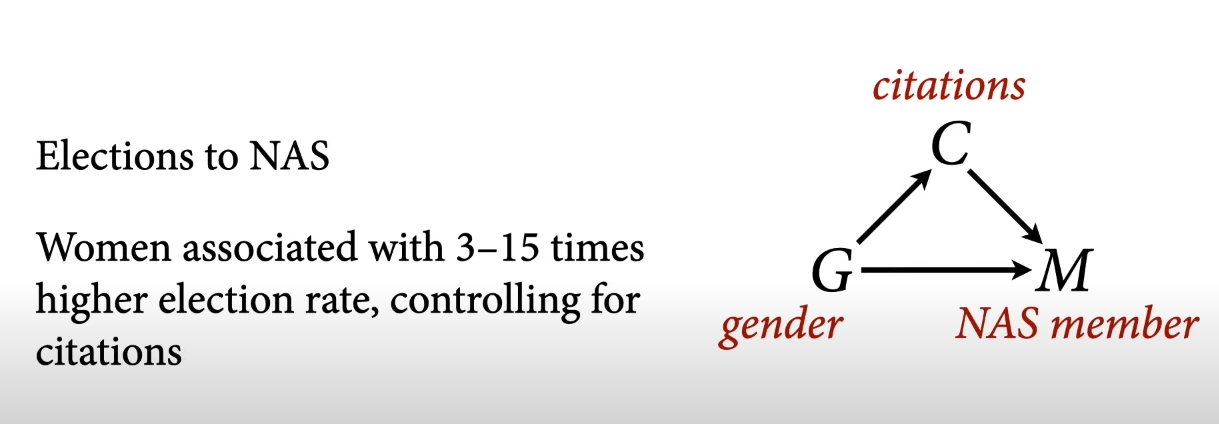

* Very plausable that there are strong quality differences among NSA members and people who are going to be elected
    * they are hidden, not the same as citations

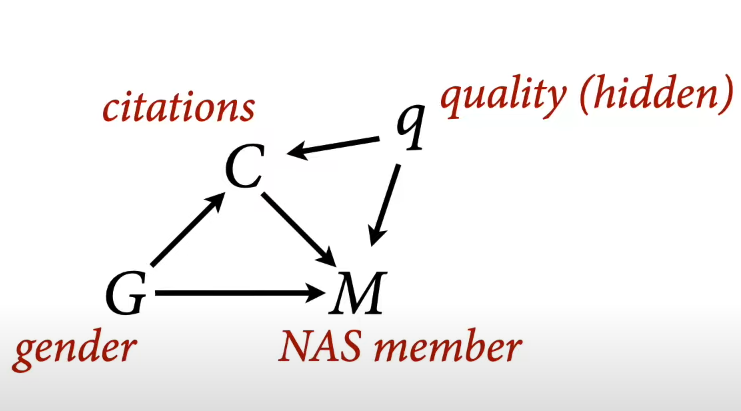

* 2nd study looks at people only already elected to NSA and looks at citation patterns and finds that women are cited less then men

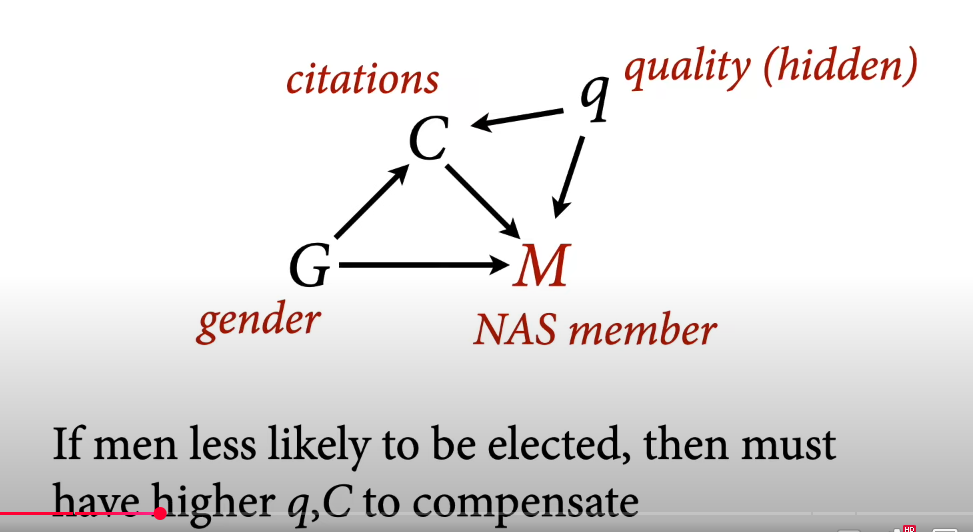
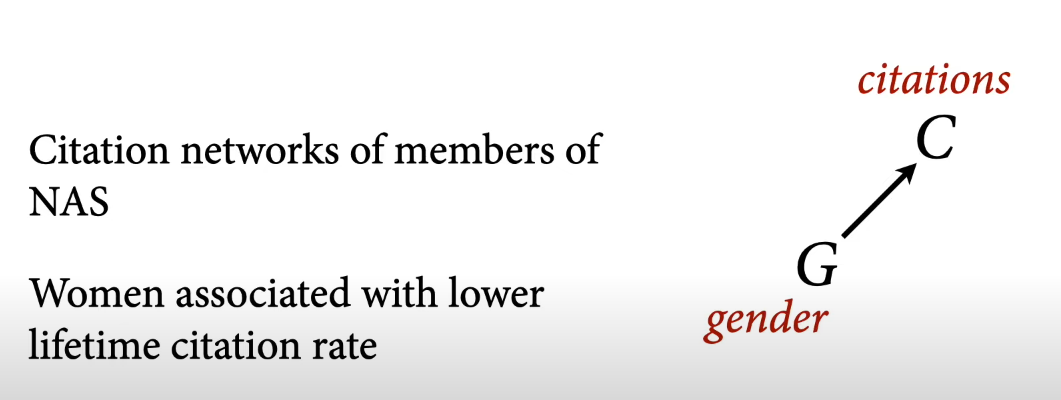

## Sensitivity Analysis: Modeling latent ability confound variable

**What are the implications of things we can't measure?**

Similar to Direct Effect scenario

- Estimating Direct effect includes Department in the adjustment set
- However, stratifying by Department (collider)  opens a confounder backdoor path through unobserved ability, u

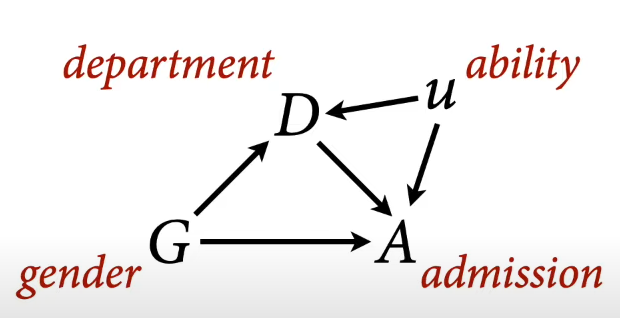

Though we can't directly measure a potential confound, what we can do is _simulate_ the degree of the effect of a potential confound. Specifically, we can set up a simulation where we create a random variable associated with the potential confound, then weight the amount of contribution that confound has on generating the observed data.

In this particular example, we can simulate the degree of effect of an ability random variable $U \sim \text{Normal}(0, 1)$, by adding a linearly weighted contribution of that variable to the log odds of Acceptance and selecting a department (this is because we u affect both D and A in our causal graph):

#### Department submodel
$$
\begin{align*}
D_i &\sim \text{Bernouilli}(q_i) \\
logit(q_i) &= \delta[G_i] + \gamma_{G[i]}  u_i \\
\delta[G_i] &\sim \text{Normal}(0, 1) \\
u_j &\sim \text{Normal}(0, 1)
\end{align*}
$$

#### Acceptance submodel
$$
\begin{align*}
A_i &\sim \text{Bernouilli}(p_i) \\
logit(p_i) &= \alpha[G_i, D_i] + \beta_{G[i]} u_i \\
\alpha[G_i, D_i] &\sim \text{Normal}(0, 1) \\
u_j &\sim \text{Normal}(0, 1)
\end{align*}
$$

Where we <span style="color:green"> **manually set the value of $\beta_{G[i]}$ and $\gamma_{G[i]}$ by hand</span>  to perform the simulation**

### Fit the latent ability model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [u, delta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


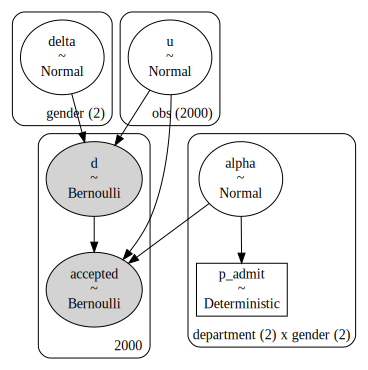

In [17]:
 # Gender-specific counterfactual parameters
# Ability confound affects admission rates equally for genders
BETA = np.array([1., 1.])

# Ability confound affects department application differently
# for genders (as is the case in generative data process)
GAMMA = np.array([1., 0.])

coords = {"gender": GENDER, "department": DEPARTMENT, "obs": np.arange(n_samples)}

with pm.Model(coords=coords) as latent_ability_model:
    
    # Latent ability variable, one for each applicant
    U = pm.Normal("u", 0, 1, dims="obs")
    
    # Department application submodel
    delta = pm.Normal('delta', 0, 1, dims='gender')
    q = pm.math.invlogit(delta[GENDER_ID] + GAMMA[GENDER_ID] * U)

    selected_department = pm.Bernoulli('d', p=q, observed=D)
    
    # Acceptance submodel
    alpha = pm.Normal("alpha", 0, 1, dims=["department", "gender"])
    p = pm.math.invlogit(alpha[GENDER_ID, selected_department] + BETA[GENDER_ID] * U)
    pm.Bernoulli('accepted', p=p, observed=A)
    
    # Record p(A | D, G) for reporting
    p_admit = pm.Deterministic("p_admit", pm.math.invlogit(alpha), dims=['department', 'gender'])
    
    latent_ability_inference = pm.sample()
    
pm.model_to_graphviz(latent_ability_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[CompSci(D2), Female (G1)]",-2.385,0.122,-2.604,-2.152,0.002,0.002,2722.0,1420.0,1.0
"alpha[CompSci(D2), Male (G2)]",-1.912,0.273,-2.466,-1.426,0.005,0.003,3203.0,1492.0,1.0
"alpha[Medical Dept(D1), Female (G1)]",-1.808,0.183,-2.147,-1.465,0.004,0.003,2671.0,1413.0,1.0
"alpha[Medical Dept(D1), Male (G2)]",-1.143,0.097,-1.308,-0.953,0.002,0.001,2951.0,1585.0,1.0
"p_admit[CompSci(D2), Female (G1)]",0.085,0.009,0.069,0.104,0.000,0.000,2722.0,1420.0,1.0
"p_admit[CompSci(D2), Male (G2)]",0.132,0.031,0.076,0.191,0.001,0.000,3203.0,1492.0,1.0
"p_admit[Medical Dept(D1), Female (G1)]",0.142,0.022,0.101,0.183,0.000,0.000,2671.0,1413.0,1.0
"p_admit[Medical Dept(D1), Male (G2)]",0.242,0.018,0.212,0.277,0.000,0.000,2951.0,1585.0,1.0


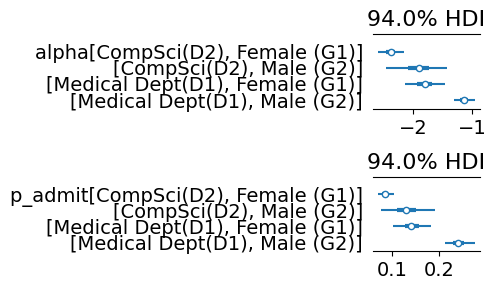

In [18]:
summarize_posterior(latent_ability_inference)

### Interpreting the Effect of modeling the confound

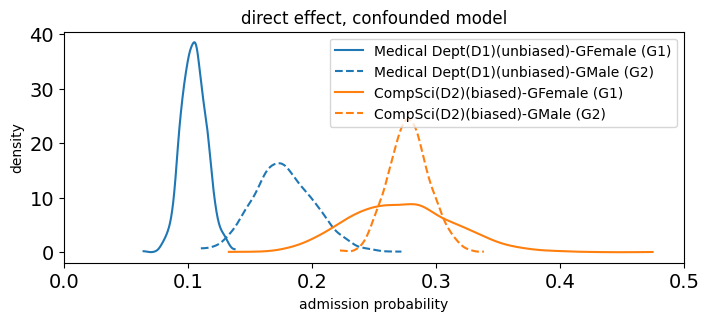

In [19]:
plot_department_gender_admissions(direct_effect_addmissions_confounded_inference, 'direct effect, confounded model')

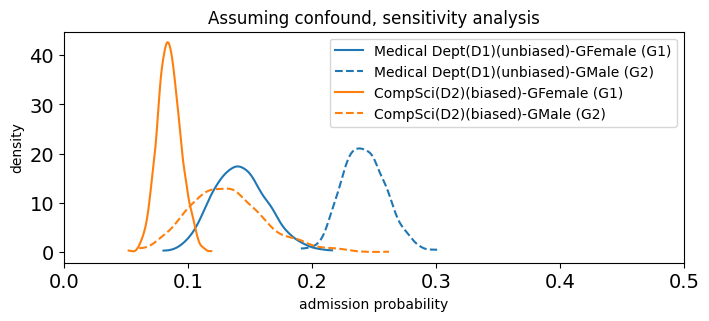

In [20]:
plot_department_gender_admissions(latent_ability_inference, "Assuming confound, sensitivity analysis") # LABELS ARE FUCKED

# Counts and Poisson Regression
## Kline & Boyd Oceanic Technology Dataset

How is technological complexity in a society related to population size?

**Estimand**: Influence of **population size** and **contact** on **total tools**

In [21]:
# Load the data
KLINE = utils.load_data("Kline")
KLINE

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


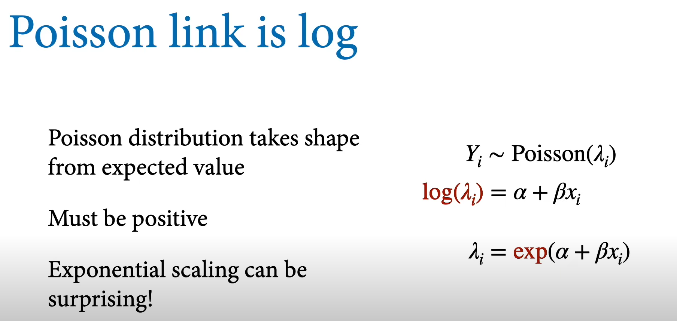

#### Poisson Priors
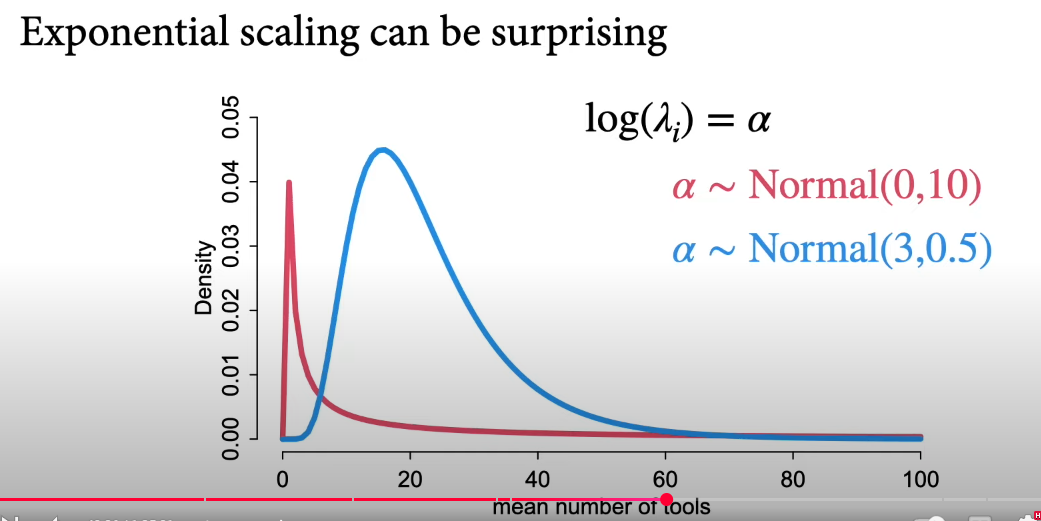
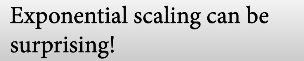
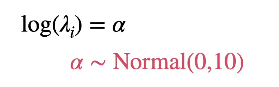

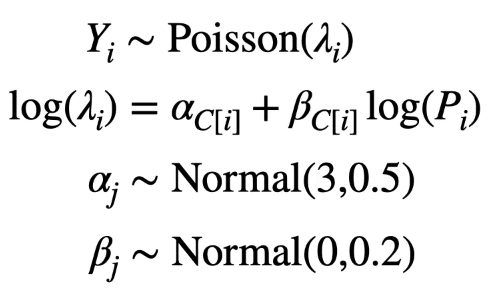

#### Total effect of population on tools model
* Stratify by:
    * contact
    * Location (ignore for now)

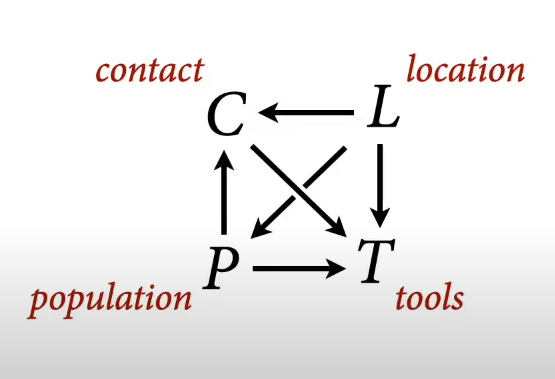

#### Model A) A simple, global intercept Poisson GLM
Here we model tools count as a Poisson random variable. The poisson rate parameter is the exponent of a linear model. In this linear model, we include only an offset for low- or high- contact populations

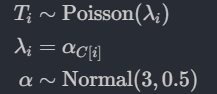

In [23]:
TOOLS = KLINE["total_tools"].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


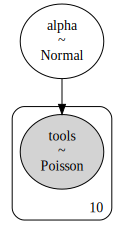

In [24]:
with pm.Model() as global_intercept_model:
    
    # Prior on global intercept
    alpha = pm.Normal('alpha', 3.0, .5)
    
    # Likelihood
    lam = pm.math.exp(alpha)
    pm.Poisson("tools", lam, observed=TOOLS)
    
    global_intercept_inference = pm.sample()
    global_intercept_inference = pm.compute_log_likelihood(global_intercept_inference)
    
pm.model_to_graphviz(global_intercept_model)

#### - Model B) 
A Poisson GLM that includes intercept and parameter for the standardized log-population, both of which are stratified by contact level


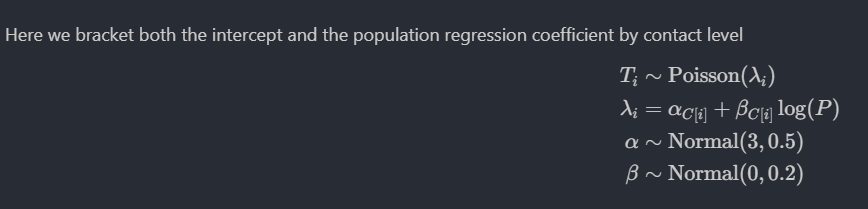

In [25]:
# contact-level
CONTACT_LEVEL, CONTACT = pd.factorize(KLINE.contact)

# Standardized log population
POPULATION = KLINE.population.values.astype(float)
STD_LOG_POPULATION = utils.standardize(np.log(POPULATION))
N_CULTURES = len(KLINE)
OBS_ID = np.arange(N_CULTURES).astype(int)

with pm.Model(coords={"contact": CONTACT}) as interaction_model:
    
    # Set up mutable data for predictions
    std_log_population = pm.MutableData("population", STD_LOG_POPULATION, dims="obs_id")
    contact_level = pm.MutableData("contact_level", CONTACT_LEVEL, dims="obs_id")
    
    # Priors
    alpha = pm.Normal("alpha", 3, .5, dims="contact")  # intercept
    beta = pm.Normal("beta", 0, .2, dims="contact")    # linear interaction with std(log(Population))
    
    # Likelihood
    lamb = pm.math.exp(alpha[contact_level] + beta[contact_level] * std_log_population)
    pm.Poisson("tools", lamb, observed=TOOLS, dims="obs_id")
    
    interaction_inference = pm.sample()

    # NOTE: For compute_log_likelihood to work for models that contain variables
    # with dims but no coords (e.g. dims="obs_ids"), we need the
    # following PR to be merged https://github.com/pymc-devs/pymc/pull/6882
    # (I've implemented the fix locally in pymc/stats/log_likelihood.py to
    # get analysis to execute)
    # 
    # TODO: Once merged, update pymc version in conda environment
    interaction_inference = pm.compute_log_likelihood(interaction_inference)

pm.model_to_graphviz(interaction_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


TypeError: object of type 'NoneType' has no len()